# Exercise 7: Sinusoidal plus residual model

In this exercise you will analyze and synthesize sounds using the Harmonic plus Stochastic (HPS) model, `hpsModel.py`. There are two questions in this exercise. In the first one you will analyze a speech sound that we give and in the second one you will analyze a sound of your choice, in both cases using the HPS model. For each question, you will first describe some of the sound characteristics by listening to the sounds and visualizing their spectrogram, characteristics that should be of relevance for the analysis/synthesis with the HPS model. Then from the described characteristics you will set the appropriate values for the different analysis parameters, explaining the choices you make, and analyze and synthesize the sounds with the HPS model software.

For this exercise, you can use `models_GUI.py`, to experiment with the parameters easily and then use them in here. Feel free to modify the code of the model if needed and add it also here. 

To help you with the exercise, we first give a brief description of the analysis parameters used by the HPS model function:

1. Window type (`window`) and Window size (`M`): The choice of window size and window type has a time-frequency trade-off. Choosing a longer window helps resolve sinusoidal components that are close in frequency, but gives a poorer temporal resolution. Shorter windows track transients better, maintaining sharp onsets, but may not resolve frequency components so well. For monophonic harmonic sounds, the window size is best chosen based on the lowest value of f0 and the fastest change in pitch.
2. FFT size (`N`): The FFT size is chosen as a power of 2 larger than the window size M. A large FFT size N, compared with M, results on an interpolated DFT spectrum and leads to better estimation of spectral peak values. However, given that the software also uses parabolic interpolation we can achieve good peak estimates with not too big FFT sizes, for example just the next power of 2 larger than M.
3. Threshold in negative dB (`t`): The peak picking threshold is the lowest amplitude peak that will be identified. Setting a very low threshold ($<-120$dB) will take most peaks, but the threshold should be set as high as possible to minimize the presence of peaks that do not correspond to sinusoidal peaks (the window main-lobe).
4. Maximum number of harmonics (`nH`): The maximum number of harmonics that can be detected in a harmonic sound is influenced by the brightness of the sound, but also by the sampling rate and by how low is the f0. The recording quality can also have an impact. For a compact representation, we should only capture the relevant harmonics, the ones that affect the perceptual quality of the reconstruction.
5. Minimum f0 frequency in Hz (`minf0`) and Maximum f0 frequency in Hz (`maxf0`): The `minf0` and `maxf0` are the parameters used by the fundamental frequency detection algorithm to obtain possible `f0` candidates to be passed to the TWM algorithm. Choosing a correct range of `f0`, but the smallest possible, greatly improves the `f0` estimation by TWM algorithm, specially minimizing octave errors, which are very common in `f0` detection algorithms. You should select the values by first looking at the spectrogram of the sound and identifying the lowest and highest fundamental frequencies present.
6.  Threshold in the f0 detection (`f0et`): This is the maximum error allowed in the TWM algorithm. If the value is too large, the algorithm might detect fundamental frequencies that might not be actually so. Instead, if is it too small, good fundamental frequencies might not be detected, returning value 0 at that frame. The smaller the value the more restrictive the algorithm behaves. A normal strategy is to start with a big value ($> 10$) and then making it smaller until we only keep what we consider to be the relevant f0 components, discarding the \texttt{f0} values in the parts of the sound that do not have a clear harmonic structure.
7. Slope of harmonic deviation (`harmDevSlope`): Slope of the harmonic deviation allowed in the estimated harmonic frequencies, compared to a perfect harmonic frequencies. If the value is 0 it means that we allow the same deviation for all harmonics, which is hard coded to \texttt{f0}$/3$. A value bigger than 0 means that higher harmonics will be allowed to deviate more than the lower harmonics from perfect harmonicity (which is a common behaviour). It normally works better to have a value slightly bigger than 0, for example around 0.01.
8. Minimum length of harmonics (`minSineDur`): Any harmonic track shorter, in seconds, than minSineDur will be removed. This is a good parameter for discarding harmonic tracks that are too short and thus that do not correspond to stable harmonics of the sound. Typically we put a value bigger that 0.02 seconds.
9. Decimation factor of magnitude spectrum for stochastic analysis (`stocf`): The stochastic approximation of the residual is a decimated version of the magnitude spectrum of the residual. This leads to a compact and smooth function that approximates the magnitude spectrum of the residual at each frame. The smaller the stocf, higher the decimation will be and thus will result in a more compact representation. A value of 1 means no decimation, leaving the residual magnitude spectrum as it is. A value of 0.2 (a good starting value) will decimate the original residual magnitude spectrum by a factor of 1/5.

The most compact and useful representation of a sound, least number of analysis data values while maintaining the sound quality in the synthesis, will be obtained by using a high t, a small `nH`, a small decimation factor for stochastic analysis, stocf, and by succeeding in detecting only the harmonics they are perceptually relevant. The values of `nH`, `minf0` and `maxf0` should be chosen by first visualizing the spectrogram of the sound with a large enough window size. There is usually a range of all parameter values for which we get a good reconstruction. Also the analysis parameters are not independent of each other and hence they need to be considered together. For testing if the detection of the harmonics have been done correctly (and for improving it) it is very useful to perform the Harmonic plus Residual analysis/synthesis (HPR model) using the same parameters and listen to the residual component for possible artifacts resulting from the harmonic analysis.

## Part 1. Obtain a good harmonic+stochastic analysis of a speech sound

Analyze and synthesize the `sound speech-female.wav`, available from the sounds directory, using `hpsModelAnal()` and `hpsModelSynth()` from the `hpsModel.py` module. The goal is to obtain the best possible reconstruction using the most compact representation. Perform the following two tasks:

1. Analyze the sound with the STFT using `models-GUI.py`, or with any other analysis tool you might wish, and describe the characteristics of the sound that might be relevant to perform the HPS analysis. Specially important characteristics for the analysis include pitch range and maximum number of harmonics. Explain the sound: write no more than a paragraph for this description.
2. Select the analysis parameters that give a good reconstruction and at the same time result in the most compact representation possible, specially related to the number of harmonics and the number of stochastic coefficients. We recommend that you first perform the harmonic plus residual analysis and by listening to the residual make some decisions on the best parameters to use. You can listen to the output sounds (harmonic, residual, stochastic components) and fine tune the parameters. Save the output sounds. Explain the choices for the following parameters: window type, window size, FFT size, minimum f0, _maximum f0, error threshold in f0 detection, number of harmonics, and stochastic decimation factor. Explain the analysis: in your descriptions do not use more than one sentence per parameter.

__Example:__ example of an analysis/synthesis for a male speech sound:

1. Input sound: http://freesound.org/people/xserra/sounds/317744/
2. Harmonic component: http://freesound.org/people/xserra/sounds/327139/
3. Residual component: http://freesound.org/people/xserra/sounds/327141/
4. Stochastic component: http://freesound.org/people/xserra/sounds/327137/
5. Harmonic+stochastic resynthesis: http://freesound.org/people/xserra/sounds/327140/


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import get_window
import sys, os
sys.path.append('../software/models/')
import utilFunctions as UF
import stft as STFT
import hpsModel as HPS
import IPython.display as ipd

"\nFrom the spectrogram can be seen that F0 usually spans from 100 hZ to 200 hZ,\nwith deviations (F0 going above 200 hZ) of approximately 30 hZ\n(for example, F0 approximately around 230 hZ at time t = 0.6 s).\n\nAlso, it can be seen that the prominent harmonics reach approximately 3000 hZ, and that the prominent harmonics\nare probably no more than 15. Even the ones with higher frequencies don't look like they deviate very much\ncomparing to the F0 trajectory.\n"

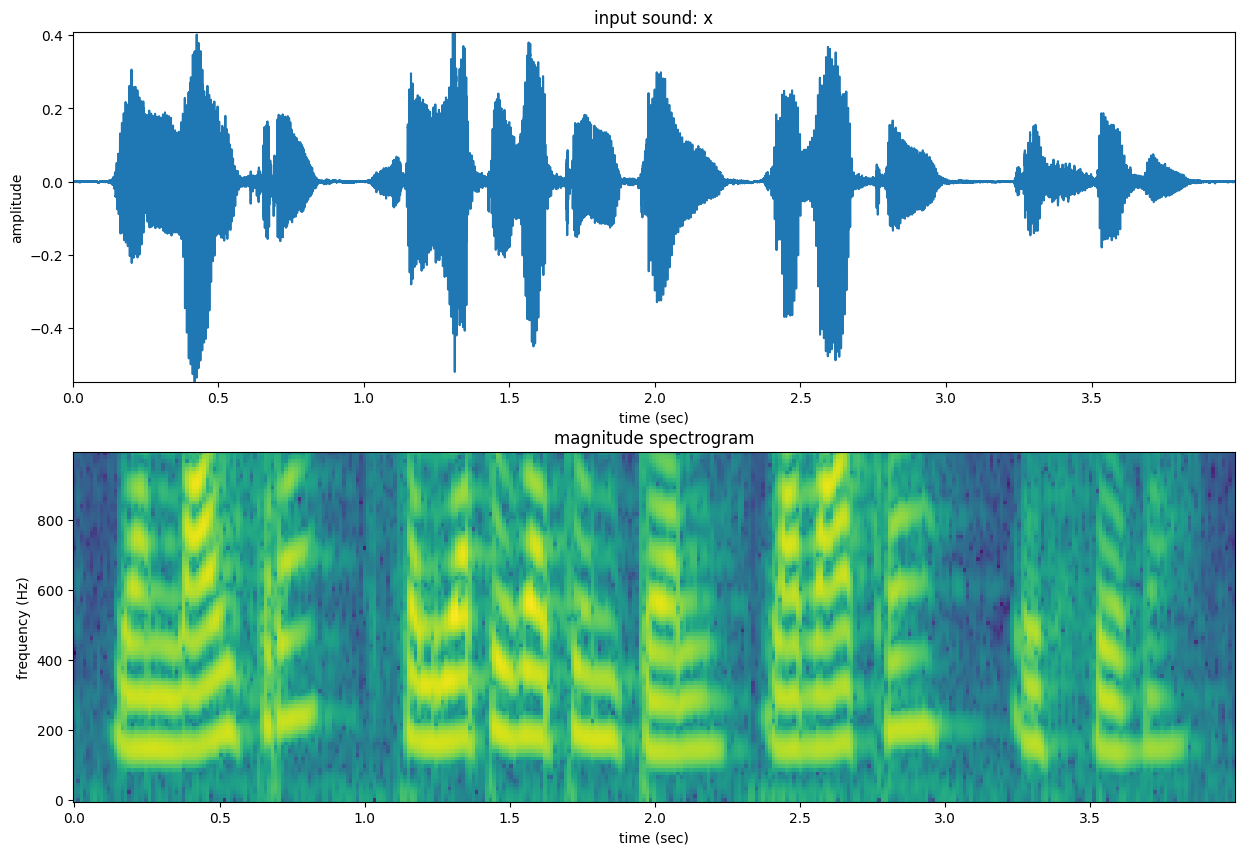

In [2]:
# E7 - 1.1: Set STFT analysis parameters and visualize spectrogram of speech-female.wav sound

input_file = '../sounds/speech-female.wav'

### set parameters
window = 'blackmanharris'
M = 2075
N = 4096
H = 518

    
# no need to modify anything after this
fs, x = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
mX, pX = STFT.stftAnal(x, w, N, H)

ipd.display(ipd.Audio(data=x, rate=fs))

plt.figure(figsize=(15, 10))
maxplotfreq = 1000.0

# plot input sound
plt.subplot(2,1,1)
plt.plot(np.arange(x.size)/float(fs), x)
plt.axis([0, x.size/float(fs), min(x), max(x)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('input sound: x')

# plot magnitude spectrogram
plt.subplot(2,1,2)
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title('magnitude spectrogram')

"""
From the spectrogram can be seen that F0 usually spans from 100 hZ to 200 hZ,
with deviations of approximately 30 hZ
(for example, F0 approximately around 230 hZ at time t = 0.6 s).

Also, it can be seen that the prominent harmonics reach approximately 3000 hZ, and that the prominent harmonics
are probably no more than 15. Even the ones with higher frequencies don't look like they deviate very much
comparing to the F0 trajectory.
"""

In [2]:
# E7 - 1.2: Perform Harmonic plus Stochastic analysis and synthesis of speech-female.wav sound

input_file = '../sounds/speech-female.wav'

### fill the parameters
window ='blackmanharris'
M = 2075
N = 4096
t = -80
minSineDur = 0.01
nH = 15
minf0 = 130
maxf0 = 235
f0et = 30
harmDevSlope = 0.3
stocf = 0.5

# no need to modify anything after this
Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

# Explain the HPS analysis parameters used
"""
Window type:
I tried with Hamming window (which basically provides a much smaller M) but the results were slightly worse
than Blackmanharris window, which is the same choice (together with M) of the spectrogram computation
(in the stochastic model the window type is not important, but in the sinusoidal/harmonic model
having a good frequency resolution for sinewaves discrimination is important).

Window size:
The formula would give (8 * (44100 / 130)) = 2713 (see "Minimum f0"); I reduced it (still maintaining an odd number in order to
implement 0 phase windowing) in order to reach a better time resolution,
but still an acceptable frequency/time resolution compromise.

FFT size:
Smallest power of 2 greater than M

Minimum f0:
130 hZ, as seen from the spectrogram, with some tolerance applied.
Together with Maximum f0 and F0 error threshold, some trial and error was performed in order to ensure that the F0
range detection and error threshold is good enough for always picking the right F0,
throughout the entire input signal's duration.

Maximum f0:
235 hZ, as seen from the spectrogram, with some tolerance applied.
Together with Minimum f0 and F0 error threshold, some trial and error was performed in order to ensure that the F0
range detection and error threshold is good enough for always picking the right F0,
throughout the entire input signal's duration.

Error threshold in f0 detection:
30 hZ, as seen from the spectrogram, with some tolerance applied.
Together with Maximum f0 and Minimum F0, some trial and error was performed in order to ensure that the F0
range detection and error threshold is good enough for always picking the right F0,
throughout the entire input signal's duration.

Number of harmonics:
This is a quite critic parameter for deciding a "boundary" between the harmonic model and the stochastic model;
I started from 9 harmonics, which are the most prominent ones, but doing so the stochastic content would be too "rich"
(-since the stochastic model is the probabilistic modelling of the residual,
which is the whole sound content - the sinusoidal/harmonic model-)
in the summed output sound, which results in spurious "noisy" sound content,
deviating further away from an input/output identity
(this has also been tested also with the harmonic + residual model).
(The main point is, any prominent harmonic not inclueded in the harmonic model will be computed as part
of the stochastic model, which has a noisy behavior and thus can radically change the output sound)

Stochastic decimation factor:
Greater values (> 0.5) still work quite fine, but lower values (like 0.2) approximate too poorly
the stochastic component, resulting in spurious sound content.
"""

'\nWindow type:\nI tried with Hamming window (which basically provides a much smaller M) but the results were slightly worse\nthan Blackmanharris window, which is the same choice (together with M) of the spectrogram computation\n(in the stochastic model the window type is not important, but in the sinusoidal/harmonic model\nhaving a good frequency resolution for sinewaves discrimination is important).\n\nWindow size:\nThe formula would give (8 * (44100 / 130)) = 2713 (see "Minimum f0"); I reduced it (still maintaining an odd number in order to\nimplement 0 phase windowing) in order to reach a better time resolution,\nbut still an acceptable frequency/time resolution compromise.\n\nFFT size:\nSmallest power of 2 greater than M\n\nMinimum f0:\n130 hZ, as seen from the spectrogram, with some tolerance applied.\nTogether with Maximum f0 and F0 error threshold, some trial and error was performed in order to ensure that the F0\nrange detection and error threshold is good enough for always pi

## Part 2. Obtain a good harmonic+stochastic analysis of a monophonic musical phrase

Analyze and synthesize a harmonic sound of your choice from Freesound using the harmonic plus stochastic model. The goal is to obtain the best possible reconstruction using the most compact representation possible. Return an explanation of what you have done and why, together with the re-synthesized sounds.

The sound from freesound to use could be in any format, but to use the sms-tools software you will have to first convert it to be a monophonic file (one channel), sampling rate of 44100, and 16bits samples. You might also have to select a fragment of the sound.

_Part 2.1:_ Choose a sound from freesound to be analyzed, download it, and if necessary, edit it, and covert it to the right format. It should be a short monophonic musical fragment of a harmonic sound, not longer than 5 seconds. In the explanation add the freesound link of the sound selected and write a brief explanation of why you chose this sound.

_Part 2.2:_ Analyze the chosen sound with the STFT, or with any other analysis or tool you might wish, and describe the characteristics of the sound that will be relevant to perform the harmonic plus stochastic analysis. Important characteristics for the analysis include the pitch range and the maximum number of harmonics. Write no more than a paragraph.

_Part 2.3:_ Select the analysis parameters that give a good reconstruction and at the same time result in to the most compact representation, specially related to the number of harmonic and the number of stochastic coefficients. We recommend that you first perform the harmonic plus residual analysis and by listening to the residual make some decisions on the best parameters to use. You can listen to the output sounds (harmonic, residual, stochastic components) and fine tune the parameters. Save the output sounds. Explain the choices for the following parameters: window type, window size, FFT size, minimum f0, maximum f0, error threshold in f0 detection, number of harmonics, and stochastic decimation factor. In your descriptions do not use more than one sentence per parameter.

In [4]:
# E7 - 2.1: download a sound from freesound, read it with waveread, and describe it

#### your code here
input_file = '../sounds/92002__jcveliz__violin-origional.wav' # original freesound file name
(fs, x) = UF.wavread(input_file)
ipd.display(ipd.Audio(data=x, rate=fs))

### write a brief description of the sound
"""
Freesound link: https://freesound.org/people/jcveliz/sounds/92002/ 

I mainly chose this sound because I was interested in studying the "bow" (noisy/stochastic) part of a strings
(violin, viola, cello, double bass) sound and separating it from the harmonic model.
Also, this sound has a quite high quality and
respects all the characteristics requested by the sms-sools interface
(44100 hZ sample rate, 16 bit quantization, mono sound, no more than 5 seconds duration)
without any editing needed.

"""

'\nFreesound link: https://freesound.org/people/jcveliz/sounds/92002/ \n\nI mainly chose this sound because I was interested in studying the "bow" (noisy/stochastic) part of a strings\n(violin, viola, cello, double bass) sound and separating it from the harmonic model.\nAlso, this sound has a quite high quality and\nrespects all the characteristics requested by the sms-sools interface\n(44100 hZ sample rate, 16 bit quantization, mono sound, no more than 5 seconds duration)\nwithout any editing needed.\n\n'

"\nSteps that I have undertaken;\n\n1.  -  Visualize the spectrogram with quite large values of M and N (H being 1/4th of M); M = 2075, N = 4096, H = 518.\nVisually, it looks detailed enough in the frequency domain. In fact, frequency, and not time, is what we are most interested in \nin this first stage.\nThus, I can see that, by zooming on the lower harmonic (what should be the F0);\n\n- the highest F0 is slightly below 1 kHZ.\n- the lowest F0 is slightly below 500 hZ.\n- there seem to be relevant harmonics (at least the first 5 harmonics)\nat least up to 5 kHZ (highest frequency that can be seen in models_GUI.py -> STFT).\n\n2. -  With a notes/frequency conversion chart, some musical instinct and the help of a DAW's piano roll,\ntranscribe the melody and understand important parameters for performing the harmonic model analysis.\n\nnotes/frequency conversion chart; https://upload.wikimedia.org/wikipedia/commons/a/ad/Piano_key_frequencies.png .\n- the first note is an A5\n- then, the

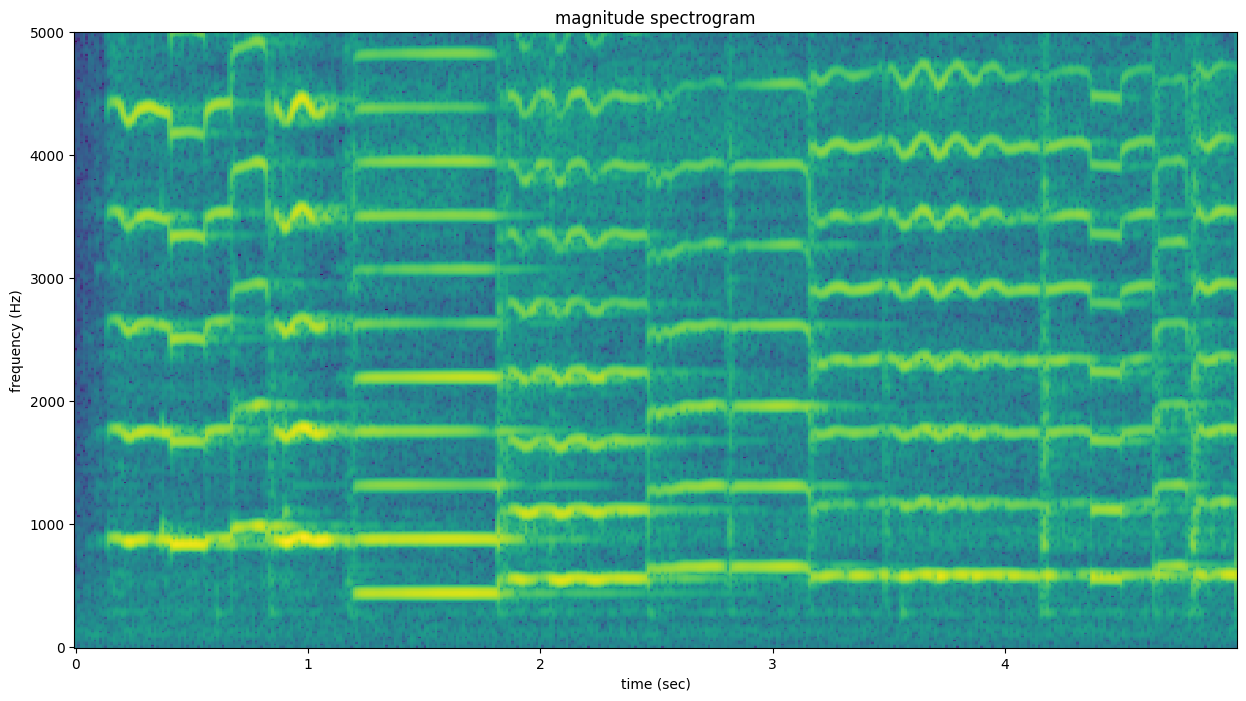

In [5]:
# E7 - 2.2: Set STFT analysis parameters and visualize spectrogram of chosen sound. Explain relevant sound 
# characteristics for HPS model

### basic visualization and listening of sound
input_file = '../sounds/92002__jcveliz__violin-origional.wav' # original freesound file name
window = 'blackmanharris'
M = 2075 # quite large starting value
N = 4096 # smallest power of 2 bigger than M
H = 518  # close to M / 4

# no need to modify anything after here
fs, x = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
mX, pX = STFT.stftAnal(x, w, N, H)

ipd.display(ipd.Audio(data=x, rate=fs))

plt.figure(figsize=(15, 8))
maxplotfreq = 5000.0
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title('magnitude spectrogram')

### Describe the characteristics relevant to perform the harmonic plus stochastic analysis
"""
Steps that I have undertaken;

1.  -  Visualize the spectrogram with quite large values of M and N (H being 1/4th of M); M = 2075, N = 4096, H = 518.
Visually, it looks detailed enough in the frequency domain. In fact, frequency resolution
, and not time resolution, is what we are most interested in 
in this first stage.
Thus, I can see that, by zooming on the lower harmonic (what should be the F0);

- the highest F0 is slightly below 1 kHZ.
- the lowest F0 is slightly below 500 hZ.
- there seem to be relevant harmonics (at least the first 5 harmonics)
at least up to 5 kHZ (highest frequency that can be seen in models_GUI.py -> STFT).

2. -  With a notes/frequency conversion chart, some musical instinct and the help of a DAW's piano roll,
transcribe the melody and understand important parameters for performing the harmonic model analysis.

notes/frequency conversion chart; https://upload.wikimedia.org/wikipedia/commons/a/ad/Piano_key_frequencies.png .
- the first note is an A5
- then, the highest pitch in the melody is a B5
- then, the lowest pitch in the melody is an A4 (440 hZ). This is important for calculating M.
"""


In [14]:
# E7 - 2.3: Perform Harmonic plus Stochastic analysis and synthesis of chosen sound


### fill the parameters
input_file = '../sounds/92002__jcveliz__violin-origional.wav' # original freesound file name
window ='blackmanharris'
M = 821 # 8 * (44100 / 430) = 820, chosen 821 for 0 phase windowing. Then I lowered it (a lot :)) with trial and error
N = 1024 # next power of 2 bigger than M
t = -80 # If I make this higher, upper harmonics start to not be properly picked by the harmonic model, and they fall into the stochastic model, which should only contain the bow rubbing sound
minSineDur = 0.08
nH = 35 
minf0 = 430
maxf0 = 1000
f0et = 5 # vibrato taken into account by looking at the spectrogram and with some trial and error
harmDevSlope = 0.05
stocf = 0.5

# No need to modify
Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

### Explain the choices of HPS analysis parameters
"""
Window type:
I chose Blackmanharris because, even with this wide-main-lobe window, M is not too large
(Better in order to obtain a good frequency resolution with lowest side lobes when possible).

Window size;
Following the formula, M should be not less than 8 * (44100 / 430) = 820 (821 for 0 phase windowing).
In fact, since the signal is monophonic and harmonic, the smallest delta is equal to the lowest F0
(actually, the F0 is slightly higher than 430 hZ, but I put some tolerance).

FFT size;
simply, the smallest power of 2 bigger than M.

Minimum f0 (see also part 2.2);
the lowest pitche in the melody is an A4 (440 hZ), but I chose 430 hZ in order to apply some tolerance.

Maximum f0 (see also part 2.2);
the highest note in the melody is a B5, so I chose 1000 hZ applying a little bit of tolerance above that frequency.

Error threshold in f0 detection (see also part 2.2);
It is a violin sound, so vibratos should be taken into account
(prominent approximately at t = 2.0 and t = 3.5) more than other type of instruments, but anyway this value
should not be too high; the value has been choosen by looking at the spectrogram first, and then with some little
trial and error.

Number of harmonics;
Again, I think we should include as many harmonic as possible here, in order for the harmonic model to be as complete
as possible, and for the residual/stochastic model to not "occupy" the "harmonic" and louder frequencies
(which I think in this type of sound are occupied by the harmonic model); anyway, it does not make any difference
to increase this number above 35, confirmed with trial and error, while lowering this number (e.g. 30 harmonics)
makes the harmonic model frequency spectrum poorer in high frequencies, and thus the stochastic model tends to occupy
too much the upper spectrum.

Stochastic decimation factor;
I find that a stochastic decimation factor of 1/2 (0.5 means 1 sample taken every 2 samples of the residual sound)
works better in this case.
"""

'\nWindow type:\nI chose Blackmanharris because, even with this wide-main-lobe window, M is not too large\n(Better to obtain a good frequency resolution with lowest side lobes when possible).\n\nWindow size;\nFollowing the formula, M should be not less than 8 * (44100 / 430) = 820 (821 for 0 phase windowing).\nIn fact, since the signal is monophonic and harmonic, the smallest delta is equal to the lowest F0\n(actually, the F0 is slightly higher than 430 hZ, but I put some tolerance).\n\nFFT size;\nsimply, the smallest power of 2 bigger than M.\n\nMinimum f0 (see also part 2.2);\nthe lowest pitche in the melody is an A4 (440 hZ), but I chose 430 hZ in order to apply some tolerance.\n\nMaximum f0 (see also part 2.2);\nthe highest note in the melody is a B5, so I chose 1000 hZ applying a little bit of tolerance above that frequency.\n\nError threshold in f0 detection (see also part 2.2);\nIt is a violin sound, so vibratos should be taken into account\n(prominent approximately at t = 2.0 a